# <center>A/B Test - Analysis of Experiment Results</center>

<div align="center"> 
        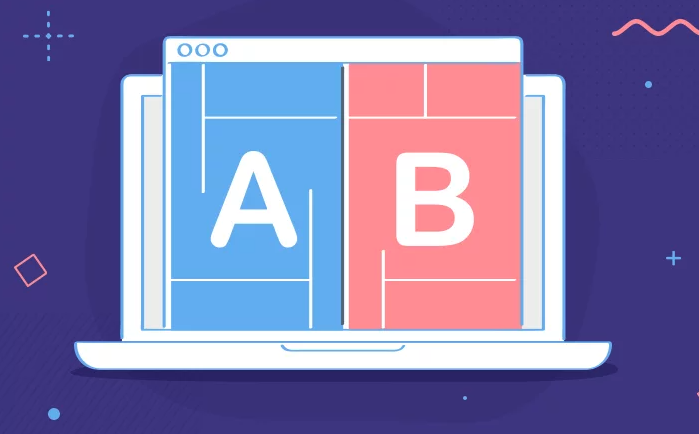
</div>

The main motivation of this notebook is to analyze results of the experiment. The data for the results are anonymised and are organised into just two columns:
- **experimentVariant** - information indicating whether the data object belongs to **Control** or **Treatment** group 
- **value** - metric value of the data object that the treatment was intended to change

Every data object will be regarded as a client by us. Revenue is chosen to be a metric, for which we have values. The primary goal of the experiment is to determine whether a new product feature affects customer behaviour favourably and increases revenue.  

<a id='top'></a>
The notebook's structure:
    
I. [EDA](#eda)

&nbsp; &nbsp; 1. [Initial Data Analysis](#init_da)<br>

&nbsp; &nbsp; 2. [Statistical Tests for Analysis of Distributions](#stat_tests)<br>


II. [Hypothesis Testing](#hypothesis_testing)

&nbsp; &nbsp; 1. [Student's t-test](#t_test)<br>

&nbsp; &nbsp; 2. [Mann–Whitney U test](#u_test)<br>

&nbsp; &nbsp; 3. [Bootstrap](#bootstrap)<br>


III. [Summary](#summary)

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

%matplotlib inline

In [2]:
sns.set(style = 'whitegrid')

<a id='eda'></a>
# I. EDA

<a id='init_da'></a>
## I-1. Initial Data Analysis

In [3]:
df = pd.read_csv('data/results_for_two_groups.csv', sep = ';').drop(columns = 'Unnamed: 0')
df['value'] = df['value'].str.replace(',', '.').astype(float)
print(df.shape)

df.head()

(1000, 2)


,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


There are no missing values in data.

In [5]:
df['experimentVariant'].value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

The number of clients in both groups is the same. Every one has five hundred.

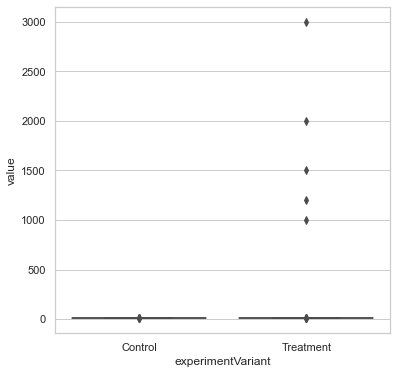

In [6]:
plt.figure(figsize = (6, 6))
sns.boxplot(data = df, y = 'value', x = 'experimentVariant', orient = 'v');

Treatment group contains few abnormal cases.

In [7]:
df.query("value > 500")

,value,experimentVariant
995,1000.0,Treatment
996,1200.0,Treatment
997,1500.0,Treatment
998,2000.0,Treatment
999,3000.0,Treatment


There are only **five** abnormal cases in treatment group. Let's examine revenue distribution in both goups once more, excluding those abnormal cases this time.

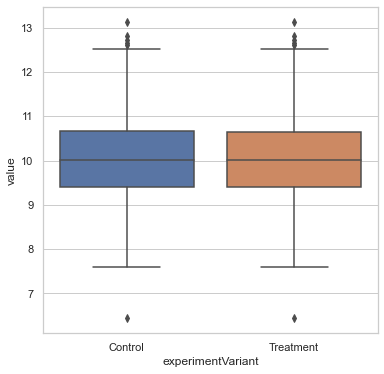

In [8]:
plt.figure(figsize = (6, 6))
sns.boxplot(data = df.query("value < 1000"), y = 'value', x = 'experimentVariant', orient = 'v');

In [9]:
df.query("value < 1000")['value'].describe().loc[['min','max']]

min     6.436541
max    13.130346
Name: value, dtype: float64

It is evident that the revenue ranges in the two groups differ considerably from abnormal cases. Abnormal cases have revenue figures that are hundreds of times higher. There's a high probability that these five examples' recoding involved a technical glitch.

[back to top](#top)

<a id='stat_tests'></a>
## I-2. Statistical Tests for Analysis of Distributions

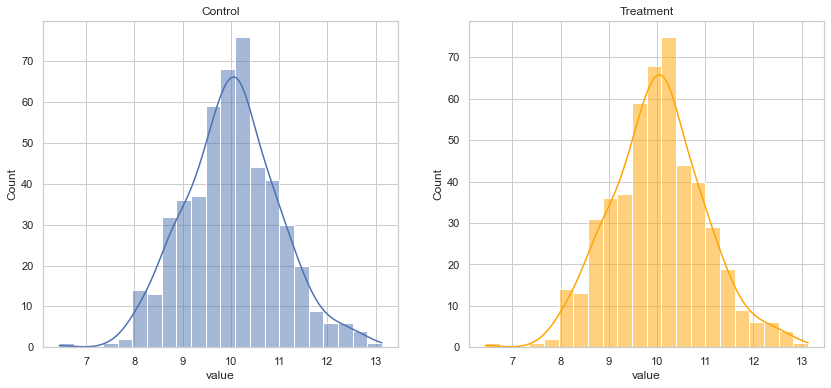

In [10]:
f, axes = plt.subplots(1, 2, figsize = (14, 6))
sns.histplot(data = df.query("experimentVariant == 'Control'"), x = 'value', ax=axes[0], kde = True)
axes[0].title.set_text('Control')

sns.histplot(data = df.query("experimentVariant == 'Treatment' and value < 1000"), x = 'value', 
             ax=axes[1], color = 'orange', kde = True)
axes[1].title.set_text('Treatment')
plt.show()

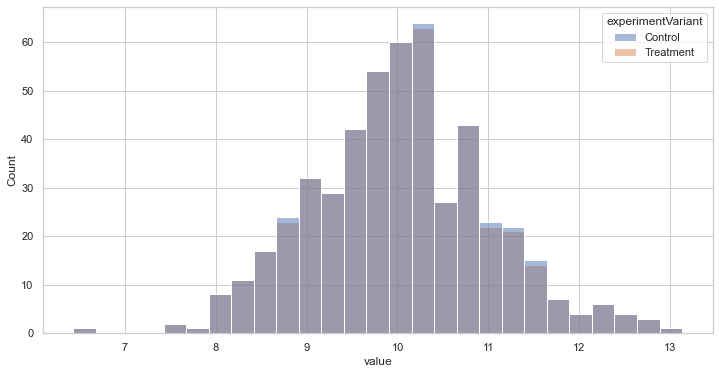

In [11]:
plt.figure(figsize = (12, 6))
sns.histplot(data = df.query('value < 1000'), x = 'value', hue = 'experimentVariant');

Revenue distributions in both groups (without taking into account five abnormal cases from the treatment group) look similar to each other and to the normal one. Let's analyse them using a few statistical tests.

### Normality test
[D'Agostino-Pearson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) test will be used to identify whether our samples differ from a normal distribution.

In [12]:
stats.normaltest(df.query("experimentVariant == 'Control'")['value'])

NormaltestResult(statistic=2.943458720256407, pvalue=0.2295282048395919)

In [13]:
stats.normaltest(df.query("experimentVariant == 'Treatment' and value < 1000")['value'])

NormaltestResult(statistic=3.4264513588191425, pvalue=0.18028331749803517)

In [14]:
stats.normaltest(df.query("experimentVariant == 'Treatment'")['value'])

NormaltestResult(statistic=929.5157667884811, pvalue=1.439513760946726e-202)

In the case of excluding abnormal cases, we have a p-value > 0.05, which leads to the conclusion that values in both groups are distributed normally.

At the same time, abnormal cases have a big impact on test results for the treatment group. Taking them into account leads to the conclusion that treatment values are not from a normal distribution.

### Test for Homogeneity of Variance
[Levene test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html) will be used to check that our samples are from populations with equal variances.

In [15]:
stats.levene(df.query("experimentVariant == 'Control'")['value'],
            df.query("experimentVariant == 'Treatment' and value < 1000")['value'])

LeveneResult(statistic=0.004297981921358907, pvalue=0.9477421313655946)

In [16]:
stats.levene(df.query("experimentVariant == 'Control'")['value'],
            df.query("experimentVariant == 'Treatment'")['value'])

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)

Without abnormal cases, p-value > 0.05, variances between groups are equal. If we take abnormal cases into account, the p-value is 0.039, which says that variances are different.

[back to top](#top)

<a id='hypothesis_testing'></a>
# II. Hypothesis Testing

Let's formualte hypotheses in our case:

 - **H0**: average revenue values in both groups are **identical**
 - **H1**: average revenue values in treatment and control groups are **different**

<a id='t_test'></a>
## II-1. Student's t-test

In order to use t-test two requirements have to be fulfilled: both samples should be from a normal distribution, and both variances should be homogeneous. In our case, these conditions are met if we don't take into account abnormal cases from the treatment group.

In [17]:
stats.ttest_ind(df.query("experimentVariant == 'Control'")['value'],
            df.query("experimentVariant == 'Treatment' and value < 1000")['value'])

Ttest_indResult(statistic=0.08299135107595523, pvalue=0.9338751428058142)

Just out of curiosity, let's check the results of the t-test, taking into account abnormal cases.

In [18]:
stats.ttest_ind(df.query("experimentVariant == 'Control'")['value'],
            df.query("experimentVariant == 'Treatment'")['value'])

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

Outliers have a huge impact on t-test results.

[back to top](#top)

<a id='u_test'></a>
## II-2. Mann–Whitney U test

U-statistic is less sensitive to outliers. Data samples don't have to be from a normal distribution as well.

In [19]:
stats.mannwhitneyu(df.query("experimentVariant == 'Control'")['value'],
            df.query("experimentVariant == 'Treatment' and value < 1000")['value'])

MannwhitneyuResult(statistic=124189.5, pvalue=0.9228386264147465)

In [20]:
stats.mannwhitneyu(df.query("experimentVariant == 'Control'")['value'],
            df.query("experimentVariant == 'Treatment'")['value'])

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

There are identical results in both cases. We can't reject the null hypothesis if p-value > 0.05.

[back to top](#top)

<a id='bootstrap'></a>
## II-3. Bootstrap

More detailed information about bootstrap can be seen [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html).

In [21]:
def get_bootstrap(
    data_column_1, # values from first sample
    data_column_2, # values from second sample
    boot_it = 1000, # number of bootstrap iterations
    statistic = np.mean, # statistic that is going to be measured
    bootstrap_conf_level = 0.95 # level of confidence
):
    boot_data = []
    for i in tqdm(range(boot_it)): # generating synthetic samples for each bootstrap iteration
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # each synthetic sample is generated with replacement
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - apply the stats
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Visualisation
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

#### With Abnormal Cases

  0%|          | 0/1000 [00:00<?, ?it/s]

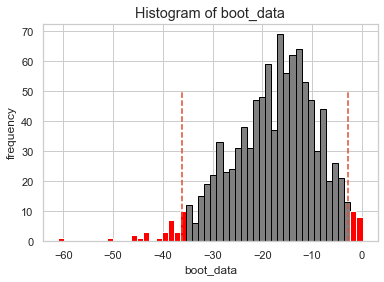

In [22]:
booted_data = get_bootstrap(df.query("experimentVariant == 'Control'")['value'], 
                            df.query("experimentVariant == 'Treatment'")['value'])

In [23]:
booted_data["p_value"]

0.04192727269540583

In [24]:
booted_data["quants"]

,0
0.025,-36.094911
0.975,-2.888115


#### Without Abnormal Cases

  0%|          | 0/1000 [00:00<?, ?it/s]

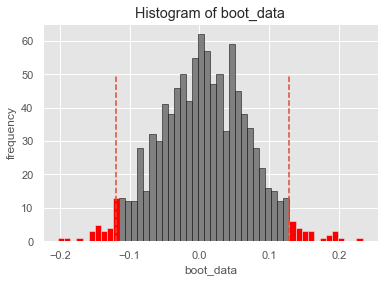

In [25]:
booted_data = get_bootstrap(df.query("experimentVariant == 'Control'")['value'], 
                            df.query("experimentVariant == 'Treatment' and value < 1000")['value'])

In [26]:
booted_data["p_value"]

0.9258227214688906

In [27]:
booted_data["quants"]

,0
0.025,-0.119120
0.975,0.127741


Results are similar to t-test. Abnormal cases have a huge impact on results.

[back to top](#top)

<a id='summary'></a>
# III. Summary

- The treatment group contains five abnormal cases. Their values are hundreds of times higher than typical values for revenue. Very likely, during the recoding of the data for these observations, a technical glitch took place. It will be better to remove them from the analysis.


- Without abnormal cases, the required conditions for the t-test are met. Both groups have samples from a normal distribution, and their variances are homogeneous.


- All three tests (without abnormal cases) show the same results: the p-value is in the range of 0.92–0.93. These results don't allow us to reject the null hypothesis. **It means that there are no statistically significant differences in revenues between treatment and control groups.** New feature in the product haven't led to any positive changes.


- Abnormal cases change the t-test and bootstrap results to the opposite ones.


- If there is no opportunity to identify the root cause of abnormal cases, it is safer to use the Mann-Whitney U test. It is not sensitive to outliers.

[back to top](#top)